# Cash Karp method & non-smooth problem

The [Cash Karp](https://doi.org/10.1145/79505.79507) variable order explicit runge kutta method is created for non-smooth problems. Here I show the performance on a simplified problem: F2 from the [DETEST](http://perso.ensta-paristech.fr/~chapoutot/integration/docs/p1-enright.pdf) set.

The class `CK45` codes the variable order Runge-Kutta method as described by Cash and Karp. The class `CK45_o` is a *fixed order* variant that uses only the fifth order method and fourth order error estimate from `CK45`. The two methods will be compared for this non-smooth problem.

## Problem definition

This problem has a discontinuity at each integer value of `t`, but this will not be exploited. Such knowledge may not be available for more realistic problems. The end of t_span is reduced from 20 to 10, with respect to the original DETEST problem.

In [1]:
problem = {'fun' : lambda t, y: ( (55 - 1.5*y) if (t%2 >= 1.) else (55 - 0.5*y)),
            'y0' : [110.],
        't_span' : [0., 10.]}

## Reference solution

First a reference solution is created by solving this problem with low tolerance.

In [2]:
from scipy.integrate import solve_ivp

reference = solve_ivp(**problem, atol=1e-12, rtol=1e-12, dense_output=True)

## Solution plot

A plot of the solution clearly shows the that the solution is non-smooth. The solver does not know where to expect the discontinuous derivatives. It needs to reduce the step near most discontinuities.

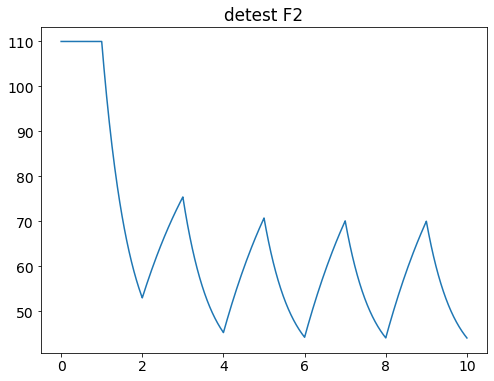

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 14

plt.figure()
plt.plot(reference.t, reference.y.T)
plt.title('detest F2')
plt.show()

## Efficiency plot
The method is efficient if it can solve problems to low error with low cost. I will use the number of function evaluations as measure of cost. For the error measure I wil use the RMS of the error norm over all solution points. A function to calculate it is:

In [4]:
def rms_err_norm(solution, reference):
    error = solution.y - reference.sol(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

Let's solve this problem with `RK45`, `CK45` and `CK45_o` at some higher absolute tolerance values and make a plot to show the efficiency of these methods. 

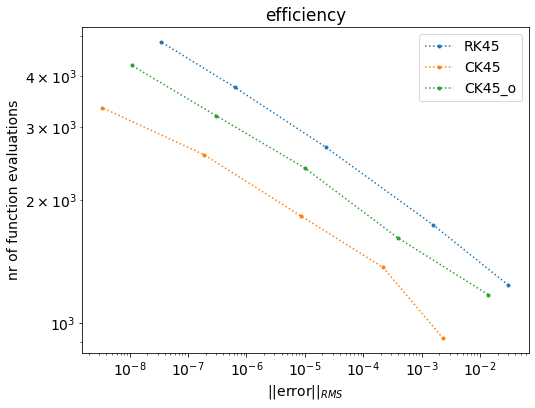

In [5]:
import numpy as np
from extensisq import CK45, CK45_o

methods = ['RK45', CK45, CK45_o]
tolerances = np.logspace(-3, -9, 5)

plt.figure()
for method in methods:
    name = method if isinstance(method, str) else method.__name__
    e = []
    n = []
    for tol in tolerances:
        sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method)
        err = rms_err_norm(sol, reference)
        e.append(err)
        n.append(sol.nfev)
    plt.loglog(e, n, '.:', label=name)
plt.legend()
plt.xlabel(r'||error||$_{RMS}$')
plt.ylabel('nr of function evaluations')
plt.title('efficiency')
plt.show()     

The variable order Cash Karp method `CK45` solves this problem roughly 1.5 times more efficiently than the `RK45` method; at least if cost is measured by the number of function evaluations. This performance is partly due to the selected coefficients, as shown by the results of `CK45_o`, but mostly by the variable order operation that Cash and Karp have built into the method.

## Discussion

The `CK45` works as advertised. It solves non-smooth problems relatively efficiently. So if your problem is non-smooth, try `CK45`.

For smooth problems `CK45` and `CK45_o` may still beat `RK45`, but the opposite could also occur. Just, give it a try for your problem, especially if you don't need low tolerance. For smooth problems and lower tolerance I reccomend `BS45_i` (or scipy's `DOP853` for even lower tolerance).